In [ ]:
#!git clone https://github.com/tGhattas/medical-images-utils.git


In [ ]:
#!pip install scikit-image==0.18.1

In [ ]:
!ls

In [1]:
import os
# os.chdir('./medical-images-utils/src')
from processor import *
from sys import platform
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import data


In [2]:
%matplotlib notebook
# %matplotlib inline

In [3]:
print(1)

1


In [4]:
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)
                
def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

<IPython.core.display.Javascript object>


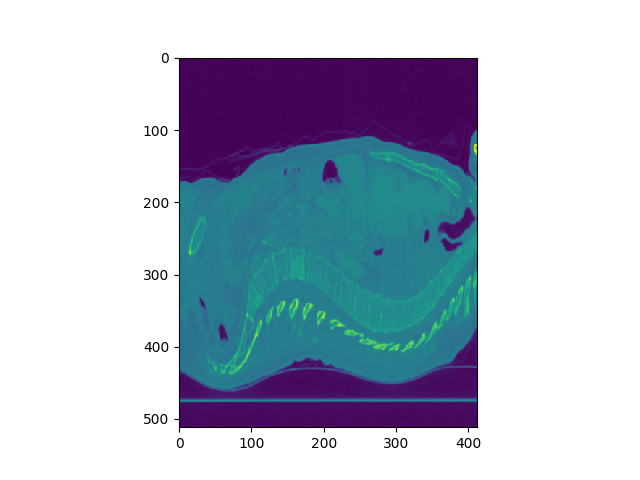

In [6]:
dir = './../data'
nifti_file = nib.load(os.path.join(dir, 'Case1_CT.nii'))
ct = nifti_file.get_fdata()
multi_slice_viewer(ct)
# plt.imshow(ct[ct.shape[0]//2:...])
# plt.show()

In [ ]:
dir = './../data'
nifti_file = nib.load(os.path.join(dir, 'Case1_CT.nii'))
ct = nifti_file.get_fdata()
P = Processor()

liver_seg = P.segmentLiver(
    os.path.join(dir, 'Case1_CT.nii'),
    os.path.join(dir, 'Case1_Aorta.nii.gz'),
    os.path.join(dir, 'out/liver_seg_1.nii.gz'))

gt = nib.load(os.path.join(dir, 'Case1_liver_segmentation.nii.gz')).get_fdata()
liver_seg = nib.load(os.path.join(dir, 'out/liver_seg_1.nii.gz')).get_fdata()
print('score---DICE %s --- VOD %s' % P.evaluateSegmentation(gt, liver_seg))

In [ ]:
!ls drive/MyDrive/Colab\ Notebooks/CT-data